# Assignment 4

**Submission deadline: last lab session before or on Wednesday, 22.11.17**

**Points: 11 + 4 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

In [1]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        """
        pass
    
    def eval_mode(self):
        """Put layer into evalation mode.
        """
        pass
    
    @property
    def parameters(self):
        return []
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = Variable(torch.FloatTensor(num_in, num_out),
                          requires_grad=True)
        self.W.name = 'W'
        self.b = Variable(torch.FloatTensor(1, num_out),
                          requires_grad=True)
        self.b.name = 'b'
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, x):
        return x.mm(self.W) + self.b

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)


class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x)

In [3]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, outputs, targets):
        return torch.mean(-torch.log(torch.gather(
            outputs, 1, targets.unsqueeze(1))))

In [4]:
from sklearn import datasets
import torchvision


iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """Simple batch gradient descent"""
    try:
        old_loss = np.inf
        x = Variable(torch.from_numpy(x), requires_grad=False)
        y = Variable(torch.from_numpy(y.astype(np.int64)), requires_grad=False)
        model.train_mode()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            for p in model.parameters:
                p.data -= p.grad.data * alpha
                # Zero gradients for the next iteration
                p.grad.data.zero_()

            loss = loss.data[0]
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}%" \
                      .format(i, loss, err_rate)
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [5]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        # p.data.normal_(0, 0.05)
        p.data.uniform_(-0.1, 0.1)
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7)

Iteration      0 | loss  1.08 | err rate  38.67%
Iteration   1000 | loss  0.06 | err rate   2.00%
Iteration   2000 | loss  0.04 | err rate   2.00%
Iteration   3000 | loss  0.04 | err rate   1.33%
Iteration   4000 | loss  0.04 | err rate   1.33%
Iteration   5000 | loss  0.04 | err rate   1.33%
Iteration   6000 | loss  0.04 | err rate   1.33%
Iteration   7000 | loss  0.04 | err rate   1.33%
Iteration   8000 | loss  0.04 | err rate   1.33%
Iteration   9000 | loss  0.04 | err rate   1.33%
Iteration  10000 | loss  0.04 | err rate   1.33%
Iteration  11000 | loss  0.04 | err rate   1.33%
Iteration  12000 | loss  0.04 | err rate   1.33%
Iteration  13000 | loss  0.04 | err rate   1.33%
Iteration  14000 | loss  0.04 | err rate   1.33%
Iteration  15000 | loss  0.04 | err rate   1.33%
Iteration  16000 | loss  0.04 | err rate   1.33%
Iteration  17000 | loss  0.04 | err rate   1.33%
Iteration  18000 | loss  0.04 | err rate   1.33%
Iteration  19000 | loss  0.04 | err rate   1.33%
Iteration  20000 | l

# Starter code for MNIST and SGD scaffolding

In [5]:
import torch
import torchvision


batch_size = 128
data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

In [6]:
def compute_error_rate(model, data_loader, cuda=False):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        x = Variable(x.view(x.size(0), -1), volatile=True)
        y = Variable(y, volatile=True)
        outputs = model.forward(x)
        _, predictions = outputs.data.max(dim=1)
        num_errs += (predictions != y.data).sum()
        num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, num_epochs=1, patience_expansion=1.5,
        log_every=100, cuda=False, alpha_c=0.99993, weight_lambda=0.001, verbose=True):
    #Initialize momentum variables
    start_alpha = alpha
    velocities = [torch.from_numpy(np.zeros(p.data.numpy().shape, dtype="float32")) for p in model.parameters]
    if cuda:
        velocities = [(torch.from_numpy(np.zeros(p.data.numpy().shape, dtype="float32"))).cuda() for p in model.parameters]
        for p in model.parameters:
            p.data = p.data.cuda()
        
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    if verbose:
        print('Training the model!')
        print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                x = Variable(x.view(x.size(0), -1), requires_grad=False)
                y = Variable(y, requires_grad=False)
                
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / out.size(0)

                history['train_losses'].append(loss.data[0])
                history['train_errs'].append(err_rate)

                for p, v in zip(model.parameters, velocities):
                    if p.name == 'W':
                        #Implement weight decay addition to gradients
                        p.grad.data -= weight_lambda*p.data
                    
                    #Update learning rate
                    #Hint: Use the iteration counter i
                    alpha = start_alpha*alpha_c**iter_
                    
                    #Set the momentum constant 
                    epsilon = 0.95
                    # Implement velocity update in momentum
                    v = epsilon*v + p.grad.data
                    
                    #Set a more sensible learning rule here,
                    #using your learning rate schedule and momentum 
                    p.data -= alpha * v
                    # Zero gradients for the next iteration
                    p.grad.data.zero_()

                if iter_ % log_every == 0 and verbose:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}% | alpha = {3: > 5.4f}" \
                          .format(iter_, loss.data[0], err_rate, alpha)
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], cuda)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.clone().cpu() for p in model.parameters]
            if verbose:
                m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                    .format(epoch, val_err_rate, num_epochs, alpha)
                print '{0}\n{1}\n{0}'.format('-' * len(m), m)

    except KeyboardInterrupt:
        pass
    if best_params is not None and verbose:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    if verbose:
        plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.58 | err rate 17.19% | alpha =  0.0497
Minibatch    200  | loss  0.56 | err rate 14.84% | alpha =  0.0493
Minibatch    300  | loss  0.21 | err rate  5.47% | alpha =  0.0490
----------------------------------------------------------
After epoch  1 | valid err rate:  7.91% | doing   4 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.33 | err rate 10.94% | alpha =  0.0486
Minibatch    500  | loss  0.27 | err rate  5.47% | alpha =  0.0483
Minibatch    600  | loss  0.19 | err rate  6.25% | alpha =  0.0479
Minibatch    700  | loss  0.27 | err rate  8.59% | alpha =  0.0476
----------------------------------------------------------
After epoch  2 | valid err rate:  6.03% | doing   5 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.19 | err rate  3.91% | alpha =  0.0473
Minibatch    900  | lo

----------------------------------------------------------
After epoch 19 | valid err rate:  2.02% | doing  25 epochs
----------------------------------------------------------
Minibatch   7500  | loss  0.03 | err rate  0.78% | alpha =  0.0296
Minibatch   7600  | loss  0.03 | err rate  0.78% | alpha =  0.0294
Minibatch   7700  | loss  0.03 | err rate  0.78% | alpha =  0.0292
Minibatch   7800  | loss  0.01 | err rate  0.00% | alpha =  0.0290
----------------------------------------------------------
After epoch 20 | valid err rate:  2.12% | doing  25 epochs
----------------------------------------------------------
Minibatch   7900  | loss  0.05 | err rate  0.78% | alpha =  0.0288
Minibatch   8000  | loss  0.01 | err rate  0.00% | alpha =  0.0286
Minibatch   8100  | loss  0.01 | err rate  0.00% | alpha =  0.0284
Minibatch   8200  | loss  0.05 | err rate  1.56% | alpha =  0.0282
----------------------------------------------------------
After epoch 21 | valid err rate:  2.11% | doing  25

Minibatch  14800  | loss  0.01 | err rate  0.00% | alpha =  0.0177
----------------------------------------------------------
After epoch 38 | valid err rate:  1.93% | doing  46 epochs
----------------------------------------------------------
Minibatch  14900  | loss  0.00 | err rate  0.00% | alpha =  0.0176
Minibatch  15000  | loss  0.00 | err rate  0.00% | alpha =  0.0175
Minibatch  15100  | loss  0.01 | err rate  0.00% | alpha =  0.0174
Minibatch  15200  | loss  0.00 | err rate  0.00% | alpha =  0.0173
----------------------------------------------------------
After epoch 39 | valid err rate:  1.89% | doing  46 epochs
----------------------------------------------------------
Minibatch  15300  | loss  0.00 | err rate  0.00% | alpha =  0.0171
Minibatch  15400  | loss  0.00 | err rate  0.00% | alpha =  0.0170
Minibatch  15500  | loss  0.02 | err rate  0.78% | alpha =  0.0169
Minibatch  15600  | loss  0.02 | err rate  0.78% | alpha =  0.0168
-------------------------------------------

Minibatch  22100  | loss  0.00 | err rate  0.00% | alpha =  0.0106
Minibatch  22200  | loss  0.00 | err rate  0.00% | alpha =  0.0106
----------------------------------------------------------
After epoch 57 | valid err rate:  1.86% | doing  65 epochs
----------------------------------------------------------
Minibatch  22300  | loss  0.00 | err rate  0.00% | alpha =  0.0105
Minibatch  22400  | loss  0.00 | err rate  0.00% | alpha =  0.0104
Minibatch  22500  | loss  0.00 | err rate  0.00% | alpha =  0.0103
Minibatch  22600  | loss  0.00 | err rate  0.00% | alpha =  0.0103
----------------------------------------------------------
After epoch 58 | valid err rate:  1.86% | doing  65 epochs
----------------------------------------------------------
Minibatch  22700  | loss  0.00 | err rate  0.00% | alpha =  0.0102
Minibatch  22800  | loss  0.00 | err rate  0.00% | alpha =  0.0101
Minibatch  22900  | loss  0.00 | err rate  0.00% | alpha =  0.0101
Minibatch  23000  | loss  0.01 | err rate  

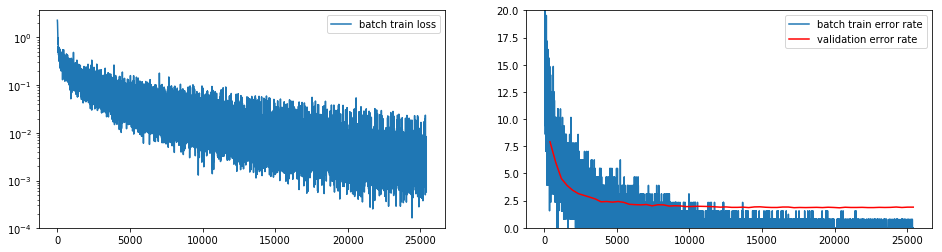

In [91]:
# TODO: Pick a network architecture here.
num_hidden = 1500
model = FeedforwardNet(
    [
     AffineLayer(784, num_hidden),
     ReLULayer(),
     AffineLayer(num_hidden, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        #p.data.normal_(0, 0.01)/np.sqrt(p.data.numpy().shape[0])
        p.data.uniform_(-0.01, 0.01)/np.sqrt(p.data.numpy().shape[0])
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=5*1e-2, cuda=True, patience_expansion=1.2)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [ ]:
weight_c = np.array([1,0.1,0.01])
num_hidden_p = np.array([500,1500,2500,3500,4500])
alpha_c = np.array([1e-1, 5*1e-2, 1e-2])
alpha_con = np.array([0.9999, 0.99993, 0.99996, 0.99999])
lambdas = np.array([0.01, 0.001, 0.0001])
distr = ['u','n']
best_err = 100.0
best_params = []
i = 0

for w in weight_c:
    for num_hidden in num_hidden_p:
        for alpha in alpha_c:
            for d in distr:
                for alp in alpha_con:
                    for lam in lambdas:
                        i+=1
                        print('Start iter '+ str(i) + ' with params: ', w, num_hidden, alpha, d, alp, lam)
                        model = FeedforwardNet(
                            [
                             AffineLayer(784, num_hidden),
                             ReLULayer(),
                             AffineLayer(num_hidden, 10),
                             SoftMaxLayer()
                            ])

                        # Initialize parameters
                        for p in model.parameters:
                            if p.name == 'W':
                                if d == 'u':
                                    p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
                                else:
                                    p.data.normal_(0, w)/np.sqrt(p.data.numpy().shape[0])
                            elif p.name == 'b':
                                p.data.zero_()
                            else:
                                raise ValueError('Unknown parameter name "%s"' % p.name)

                        # On lab computers you can set cuda=True !
                        SGD(model, mnist_loaders, alpha=alpha, cuda=False, patience_expansion=1.4, log_every=100000, alpha_c=alp, weight_lambda=lam, verbose=False)
                        err = compute_error_rate(model, mnist_loaders['test'])
                        if(err < best_err):
                            best_err = err
                            if(d == 'u'):
                                dd = 0.0
                            else:
                                dd = 1.0
                            best_params = np.array([best_err, w, num_hidden, alpha, dd, alp, lam, i], dtype="float32")
                            print best_params
                            np.savetxt('assignment4.out', best_params, fmt="%.5f")

('Start iter 1 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99990000000000001, 0.01)
[  9.01999969e+01   1.00000000e+00   5.00000000e+02   1.00000001e-01
   0.00000000e+00   9.99899983e-01   9.99999978e-03   1.00000000e+00]
('Start iter 2 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99990000000000001, 0.001)
('Start iter 3 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99990000000000001, 0.0001)
('Start iter 4 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99992999999999999, 0.01)
('Start iter 5 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99992999999999999, 0.001)
('Start iter 6 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99992999999999999, 0.0001)
('Start iter 7 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99995999999999996, 0.01)
('Start iter 8 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99995999999999996, 0.001)
('Start iter 9 with params: ', 1.0, 500, 0.10000000000000001, 'u', 0.99995999999999996, 0.0001)
('Star

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.